In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torchvision import transforms, datasets


train_nm = 'seg_train/seg_train'
val_nm = 'seg_test/seg_test'

data_transforms = {
    train_nm: transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val_nm: transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/MyDrive/intel_places_ds'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [train_nm, val_nm]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True,) for x in [train_nm, val_nm]}

dataset_sizes = {x: len(image_datasets[x]) for x in [train_nm, val_nm]}
class_names = image_datasets[train_nm].classes

In [3]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [4]:
dataset_sizes

{'seg_test/seg_test': 3000, 'seg_train/seg_train': 14034}

In [5]:
image, label = next(iter(dataloaders[train_nm]))
image.numpy().shape

(64, 3, 128, 128)

In [6]:
label

tensor([3, 4, 4, 5, 4, 5, 3, 2, 2, 4, 0, 5, 0, 4, 1, 4, 5, 2, 4, 5, 3, 0, 2, 1,
        0, 5, 1, 3, 3, 3, 1, 3, 2, 1, 5, 0, 0, 0, 0, 5, 5, 4, 0, 0, 5, 5, 3, 2,
        5, 2, 3, 0, 0, 2, 3, 5, 4, 5, 1, 3, 0, 5, 5, 1])

In [7]:
image = image.view(-1, *image.size()[2:])

(-0.5, 127.5, 127.5, -0.5)

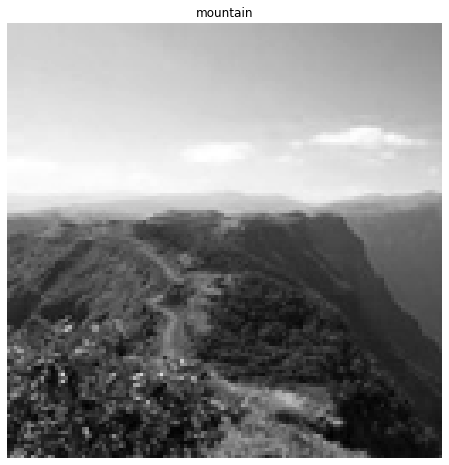

In [8]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
plt.imshow(image[0], cmap='binary_r')
plt.title(class_names[label[0]])
plt.axis('off')

In [9]:
import torchvision
import torchvision.models as models
from torch import nn

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features
n_classes = len(class_names)
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    model.cuda()

def train_model(model, dataloaders, criterion, optimizer, epochs=15):
    for epoch in range(epochs):
        print(f'\n{epoch+1} / {epochs}')
        print('-'*20)
        
        for phase in [train_nm, val_nm]:
            if phase == train_nm:
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            correct = 0
            
            for X, y in dataloaders[phase]:
                X, y = X.cuda(), y.cuda()
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == train_nm):
                    out = model(X)
                    loss = criterion(out, y)
                    _, preds = torch.max(out, 1)
                    
                    if phase == train_nm:
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * X.size(0)
                correct += torch.sum(preds == y.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase}: loss {epoch_loss:.4f}, acc {epoch_acc:.2f}')

           
train_model(model, dataloaders, criterion, optimizer, 5)


cuda:0

1 / 5
--------------------
seg_train/seg_train: loss 0.2616, acc 0.90
seg_test/seg_test: loss 0.2442, acc 0.91

2 / 5
--------------------
seg_train/seg_train: loss 0.2329, acc 0.91
seg_test/seg_test: loss 0.2411, acc 0.91

3 / 5
--------------------
seg_train/seg_train: loss 0.2219, acc 0.91
seg_test/seg_test: loss 0.2220, acc 0.92

4 / 5
--------------------
seg_train/seg_train: loss 0.2134, acc 0.92
seg_test/seg_test: loss 0.2222, acc 0.91

5 / 5
--------------------
seg_train/seg_train: loss 0.2228, acc 0.91
seg_test/seg_test: loss 0.2361, acc 0.91


In [32]:
true_labels = torch.tensor([]).to(device)
labels = torch.tensor([]).to(device)

for batch, (X, y) in enumerate(dataloaders[val_nm]):
    X, y = X.to(device), y.to(device)
    true_labels = torch.cat((true_labels, y), 0)
    preds = model(X)
    _, preds = torch.max(preds, dim=1)
    labels = torch.cat((labels, preds), 0)

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification report \n')
print(classification_report(true_labels.cpu(), labels.cpu(), target_names=class_names))
conf_matrix = confusion_matrix(true_labels.cpu(), labels.cpu(), normalize='true')
print('Confusion matrix \n')
print(conf_matrix.round(2))

Classification report 

              precision    recall  f1-score   support
   buildings       0.93      0.89      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.78      0.84       553
    mountain       0.83      0.89      0.86       525
         sea       0.94      0.98      0.96       510
      street       0.90      0.95      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Confusion matrix 

[[0.89 0.   0.   0.   0.   0.1 ]
 [0.   0.99 0.   0.   0.   0.  ]
 [0.   0.01 0.78 0.17 0.04 0.01]
 [0.   0.   0.09 0.89 0.02 0.  ]
 [0.01 0.   0.01 0.01 0.98 0.  ]
 [0.05 0.   0.   0.   0.   0.95]]


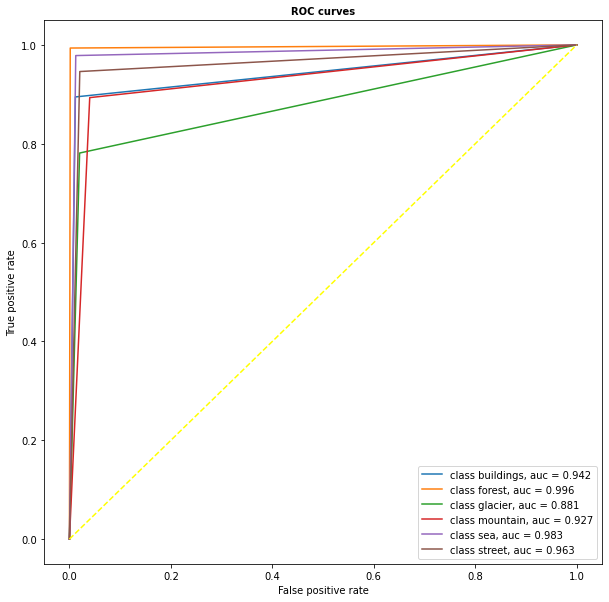

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig = plt.figure(figsize=(10, 10))

n_classes = len(class_names)
lab_plt = [(true_labels.cpu() == float(i)) for i in range(n_classes)]
outs_plt = [(labels.cpu() == float(i)) for i in range(n_classes)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curves', fontweight='bold', fontsize=10)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f'class {class_names[i]}, auc = {roc_auc[i]:.3f}' )

plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--', color='yellow')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

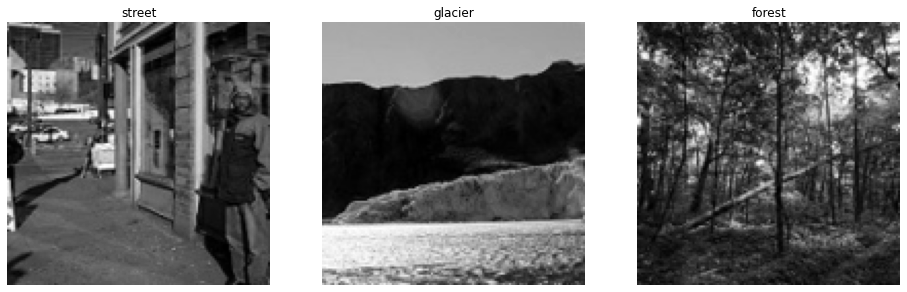

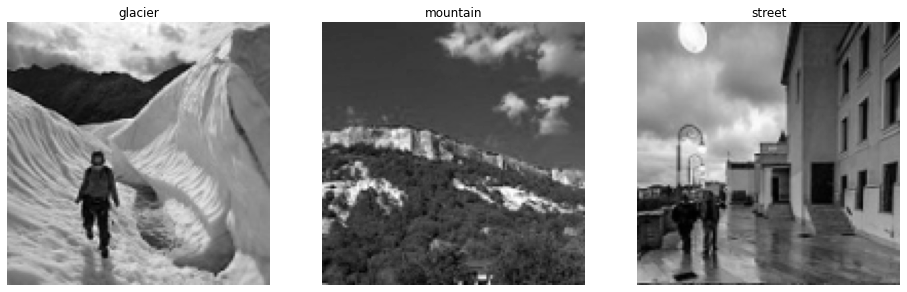

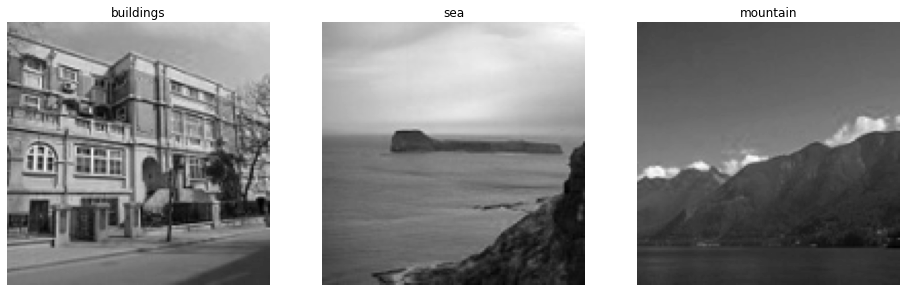

In [25]:
count = 0
for img, label in dataloaders[val_nm]:
    plt.figure(figsize=(16, 16))
    count += 1
    img = img.to(device)
    pred = model(img)
    pred = torch.max(pred, dim=1)
    img = img.view(-1, *img.size()[2:])
    for i in range(3):
        ax = plt.subplot(1, 3, 1+i)
        plt.imshow(img[i*3].cpu(), cmap='binary_r')
        plt.title(class_names[label[0+i]])
        plt.axis('off')
    if count == 3:
        break